## Pollen Detection in Honeybee Images

Given *images of honeybees*, let's try to detect **pollen** in a given image. 

We will use a Tensorflow/Keras convolutional neural network to make our predictions.

Data source: https://www.kaggle.com/datasets/ivanfel/honey-bee-pollen

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
data = pd.read_csv('archive/PollenDataset/pollen_data.csv', usecols=['filename', 'pollen_carrying'])
data

,filename,pollen_carrying
0,P10057-125r.jpg,1
1,P57380-120r.jpg,1
2,NP63671-221r.jpg,0
3,NP53776-47r.jpg,0
4,NP13382-201r.jpg,0
...,...,...
709,NP64239-233r.jpg,0
710,NP10304-132r.jpg,0
711,NP28671-238r.jpg,0
712,P14163-218r.jpg,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


### Preprocessing

In [5]:
'archive/PollenDataset/images/' / Path('NP28671-238r.jpg')

PosixPath('archive/PollenDataset/images/NP28671-238r.jpg')

In [19]:
def preprocess_df(df, image_path):
    df = df.copy()

    # Change filenames into filepaths
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)

    # Create text labels for the images
    df['pollen_carrying'] = df['pollen_carrying'].replace({0: 'NO POLLEN', 1: 'POLLEN'})
    
    # Train-test split
    train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)

    return train_df, test_df

In [20]:
train_df, test_df = preprocess_df(data, image_path = 'archive/PollenDataset/images/')

In [21]:
train_df

,filename,pollen_carrying
507,archive/PollenDataset/images/P63102-206r.jpg,POLLEN
346,archive/PollenDataset/images/NP1779-22r.jpg,NO POLLEN
160,archive/PollenDataset/images/P27661-207r.jpg,POLLEN
463,archive/PollenDataset/images/NP15065-233r.jpg,NO POLLEN
432,archive/PollenDataset/images/P6113-76r.jpg,POLLEN
...,...,...
144,archive/PollenDataset/images/P58841-154r.jpg,POLLEN
645,archive/PollenDataset/images/NP57593-129r.jpg,NO POLLEN
72,archive/PollenDataset/images/P14225-220r.jpg,POLLEN
235,archive/PollenDataset/images/NP19884-38r.jpg,NO POLLEN


In [22]:
test_df

,filename,pollen_carrying
546,archive/PollenDataset/images/NP55845-95r.jpg,NO POLLEN
223,archive/PollenDataset/images/NP1300-17r.jpg,NO POLLEN
403,archive/PollenDataset/images/NP12467-175r.jpg,NO POLLEN
8,archive/PollenDataset/images/NP59420-165r.jpg,NO POLLEN
394,archive/PollenDataset/images/P22026-79r.jpg,POLLEN
...,...,...
268,archive/PollenDataset/images/NP1149-11r.jpg,NO POLLEN
307,archive/PollenDataset/images/NP2237-28r.jpg,NO POLLEN
318,archive/PollenDataset/images/P18476-8r.jpg,POLLEN
224,archive/PollenDataset/images/NP65298-243r.jpg,NO POLLEN


### Creating Generators

In [23]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [25]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False
)

Found 400 validated image filenames belonging to 2 classes.
Found 99 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


### Training

In [31]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


/home/aditya/miniconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-11-02 08:24:28.023757: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100933632 exceeds 10% of free system memory.
2025-11-02 08:24:28.433358: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25233408 exceeds 10% of free system memory.
2025-11-02 08:24:28.493316: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48664576 exceeds 10% of free system memory.
2025-11-02 08:24:28.707657: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23887872 exceeds 10% of free system memory.

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5100 - loss: 0.6950 - val_accuracy: 0.4545 - val_loss: 0.7031
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5275 - loss: 0.6917 - val_accuracy: 0.4545 - val_loss: 0.6967
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5275 - loss: 0.6918 - val_accuracy: 0.4545 - val_loss: 0.6967
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5275 - loss: 0.6915 - val_accuracy: 0.4545 - val_loss: 0.6971
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5275 - loss: 0.6907 - val_accuracy: 0.4545 - val_loss: 0.6959
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5275 - loss: 0.6920 - val_accuracy: 0.4545 - val_loss: 0.6961
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 911ms/step - accuracy: 0.5275 - loss: 0.6891 - val_accuracy: 0.4545 - val_loss: 0.6924
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5275 - loss: 0.6858 - val_accuracy: 0.4545 - val_loss: 

### Results

In [36]:
results = model.evaluate(test_images, verbose=0)

print("Accuracy: {:.2f}%".format(results[1] * 100))

predictions = (np.squeeze(model.predict(test_images)) >= 0.5).astype(int)

Accuracy: 85.58%
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step


In [38]:
test_images.class_indices

{'NO POLLEN': 0, 'POLLEN': 1}

In [41]:
test_images.labels

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1]

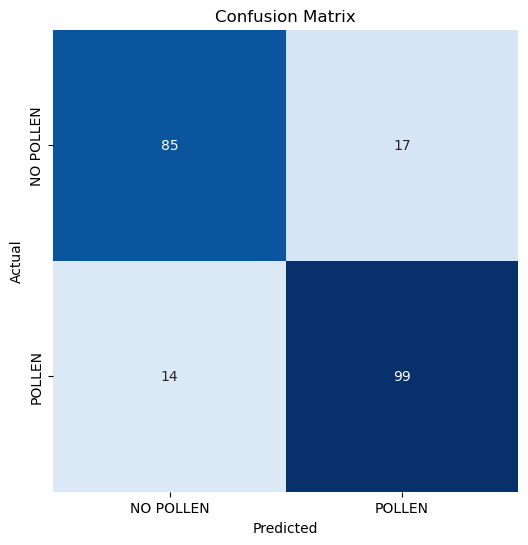

In [42]:
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0,1], target_names=['NO POLLEN', 'POLLEN'])

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['NO POLLEN', 'POLLEN'])
plt.yticks(ticks=[0.5, 1.5], labels=['NO POLLEN', 'POLLEN'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [43]:
print("Classification Report:\n-----------------------------------------\n", clr)

Classification Report:
-----------------------------------------
               precision    recall  f1-score   support

   NO POLLEN       0.86      0.83      0.85       102
      POLLEN       0.85      0.88      0.86       113

    accuracy                           0.86       215
   macro avg       0.86      0.85      0.86       215
weighted avg       0.86      0.86      0.86       215



In [47]:
test_images[0][0][5].shape

(224, 224, 3)

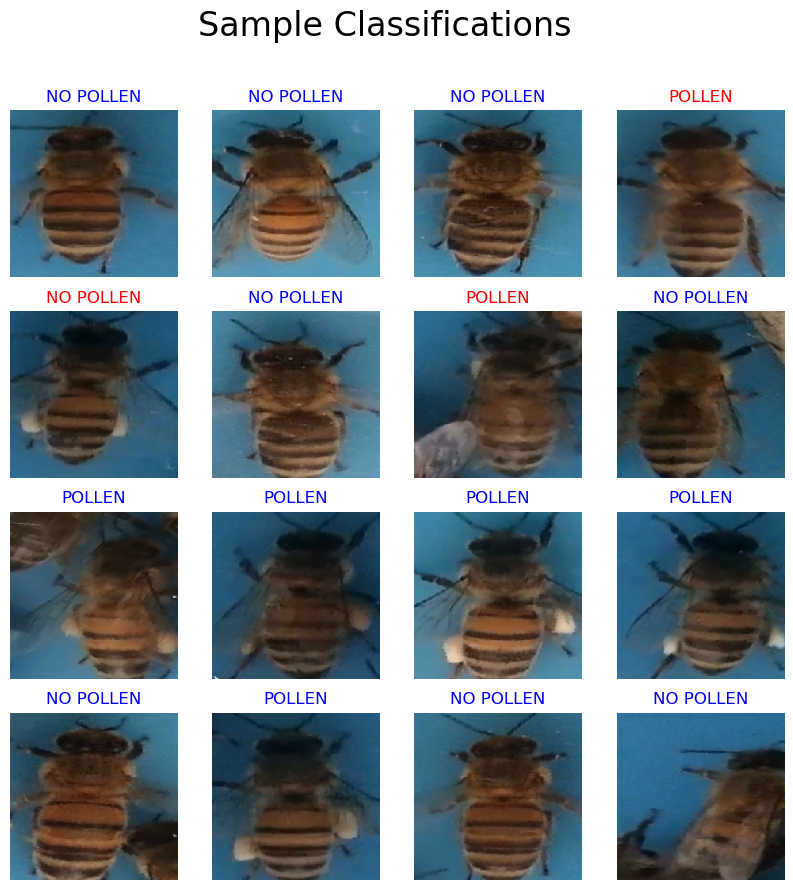

In [53]:
plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[0][0][i])
    plt.title(
        'NO POLLEN' if predictions[i] == 0 else 'POLLEN',
        color='blue' if predictions[i] == test_images.labels[i] else 'red'
    )
    plt.axis('off')

plt.suptitle('Sample Classifications', size=24)
    
plt.show()